# Neural Machine Translation


__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# ! pip3  install subword-nmt
# ! pip3 install nltk
# ! pip3 install torchtext
# ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# # Thanks to YSDA NLP course team for the data
# # (who thanks tilda and deephack teams for the data in their turn)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
import os

In [3]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

## Main part
__Here comes the preprocessing. Try to use BPE or more complex preprocessing ;)__


In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
len(train_data), len(valid_data), len(test_data)

(40000, 2500, 7500)

In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

And here is example from train dataset:

In [10]:
print(vars(train_data.examples[4]))

{'trg': ['guests', 'can', 'relax', 'on', 'the', 'terrace', 'and', 'enjoy', 'the', 'scenic', 'landscapes', '.', 'activities', 'range', 'from', 'horse', 'riding', ',', 'hiking', 'and', 'fishing', '.'], 'src': ['гости', 'могут', 'отдохнуть', 'на', 'террасе', 'и', 'полюбоваться', 'живописными', 'пейзажами', ',', 'а', 'также', 'заняться', 'верховой', 'ездой', ',', 'отправиться', 'на', 'пешую', 'прогулку', 'или', 'на', 'рыбалку', '.']}


In [11]:
len(train_data)

40000

## Model side


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [14]:
def generate_tgt_mask(shape):
    tgt_mask = torch.zeros(shape, shape)
    tgt_mask[:] = float('-inf')
    tgt_mask = torch.triu(tgt_mask,1)
    return tgt_mask

In [15]:
# For reloading 
import modules_tranformer
import imp
imp.reload(modules_tranformer)

Encoder = modules_tranformer.Encoder
Decoder = modules_tranformer.Decoder
Seq2Seq = modules_tranformer.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
METHOD = 'general'
HEADS = 8

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, N_LAYERS, HEADS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, N_LAYERS, HEADS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [16]:
# src_key_padding_mask.T

In [17]:
# enc.eval()
# enc(src, src_key_padding_mask.T)[:,:,4]

In [18]:
# _i = next(train_iterator.__iter__())
# src = _i.src
# trg = _i.trg
# # out = enc(src)
# # dec(trg, out)

In [19]:
# TRG.vocab['<sos>']

In [20]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param, -0.08, 0.08)
        
# model.apply(init_weights)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,612,240 trainable parameters


In [22]:
# src_key_padding_mask = src == SRC.vocab.stoi['<pad>']
# res = model.encoder(src, src_key_padding_mask.T)

In [23]:
# trg_inp.shape, tgt_mask.shape

In [24]:
# trg_inp, trg_out = trg[:-1], trg[1:]
# tgt_key_padding_mask = trg_inp == TRG.vocab.stoi['<pad>']
# tgt_mask = generate_tgt_mask(trg_inp.shape[0]).to(device)
# x = model.decoder(trg_inp, res, tgt_key_padding_mask.T, tgt_mask)

In [25]:
# model(src, trg_inp, src_key_padding_mask.T, tgt_key_padding_mask.T,tgt_mask)

In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        #print(i)
        src = batch.src
        trg = batch.trg
        trg_inp, trg_out = trg[:-1], trg[1:]
        tgt_mask = generate_tgt_mask(trg_inp.shape[0]).to(device)
        src_key_padding_mask = src == SRC.vocab.stoi['<pad>']
        tgt_key_padding_mask = trg_inp == TRG.vocab.stoi['<pad>']
        #print(trg.shape, tgt_mask.shape)
        optimizer.zero_grad()
        
        output = model(src, trg_inp, src_key_padding_mask.T, tgt_key_padding_mask.T,tgt_mask)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        trg_out = trg_out.view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg_out)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            trg_inp, trg_out = trg[:-1], trg[1:]
            tgt_mask = generate_tgt_mask(trg_inp.shape[0]).to(device)
            src_key_padding_mask = src == SRC.vocab.stoi['<pad>']
            tgt_key_padding_mask = trg_inp == TRG.vocab.stoi['<pad>']
            output = model(src,trg_inp,src_key_padding_mask.T, tgt_key_padding_mask.T, tgt_mask, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output.view(-1, output.shape[-1])
            trg_out = trg_out.view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg_out)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [28]:
# src.shape, src_key_padding_mask.shape

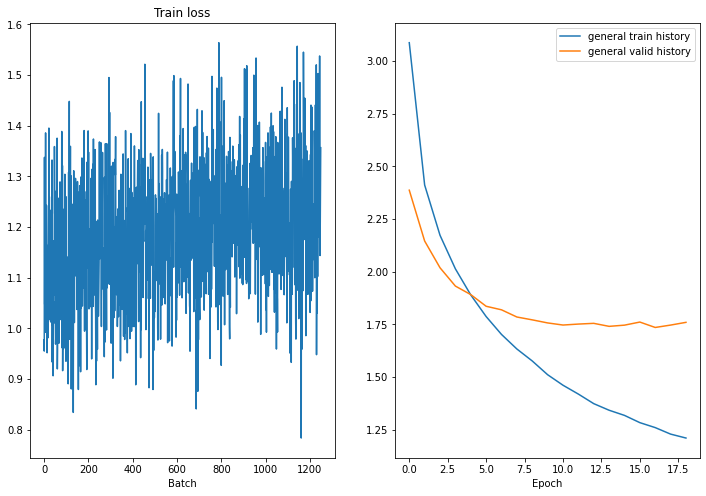

Epoch: 20 | Time: 0m 54s
	Train Loss: 1.186 | Train PPL:   3.275
	 Val. Loss: 1.765 |  Val. PPL:   5.841


In [29]:
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
     
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [30]:
model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [31]:
def translate(src, max_len):
    model.eval()
    trg = torch.tensor([[TRG.vocab['<sos>']]*src.shape[1]]).to(device)
    for i in range(max_len):
        tgt_mask = generate_tgt_mask(trg.shape[0]).to(device)
        src_key_padding_mask = src == SRC.vocab.stoi['<pad>']
        tgt_key_padding_mask = trg == TRG.vocab.stoi['<pad>']
        preds = model(src, trg,src_key_padding_mask.T, tgt_key_padding_mask.T, tgt_mask)

        predicted_words = preds.argmax(-1)[-1,:].unsqueeze(0)

        trg = torch.cat((trg, predicted_words), axis=0)
    return trg
    

In [32]:
# def translate_testing(src, max_len, trg_in):
    
#     trg = trg_in[:1]
#     for i in range(max_len):
#         #print(trg)
#         #print(trg.shape, src.shape)
#         tgt_mask = generate_tgt_mask(trg.shape[0]).to(device)
#         src_key_padding_mask = src == SRC.vocab.stoi['<pad>']
#         tgt_key_padding_mask = trg == TRG.vocab.stoi['<pad>']
#         print(src)
#         preds = model(src, trg,src_key_padding_mask.T, tgt_key_padding_mask.T, tgt_mask)
        
# #         print(trg)
#         #print(preds.max(-1))
#         #predicted_words = preds.argmax(-1)[-1,:].unsqueeze(0)
#         #print(predicted_words)
#         #print('preds', preds.argmax(-1).shape)
#         #print(trg.shape, predicted_words.shape)
#         trg = torch.cat((trg_in[:1], preds.argmax(-1)), axis=0)
#         print(preds)
#         print(preds.shape)
#         print(trg)
#         print('\n'*4)
       
#     return trg

__Let's take a look at our network quality__:

In [33]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [34]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = translate(src, 40)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

235it [00:37,  6.19it/s]


In [35]:
original_text[:3]

[['free', 'parking', 'is', 'provided', '.'],
 ['bed', 'linen', 'is', 'featured', '.'],
 ['the', 'property', 'offers', 'free', 'parking', '.']]

In [36]:
generated_text[:3]

[['the', 'property', 'offers', 'free', 'parking', '.'],
 ['bed', 'linen', 'is', 'provided', '.'],
 ['the', 'property', 'offers', 'free', 'parking', '.']]

In [37]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [38]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.323632461194176

Baseline solution BLEU score is quite low. 
The checkpoints are:

* __18__ - minimal score to submit

* __20__ - good score

* __25__ - excellent score